In this example, we show how to use our RTify framework to get reaction times(RTs). For illustrative purpose, in this example, we only use synthetic human data and relatively small model.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from utils import set_seeds
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

%matplotlib inline
set_seeds()

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# for illustative purposes, here we use FashionMNIST train set as a toy dataset
data_train = datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor())
# As an example, we will use the mean of the image as a proxy for the RTs
data_train = [(x, y, x.mean()) for x, y in data_train]
rt_array = np.array([x[2] for x in data_train])
# for our fake RT, we normalize the RTs to be between 0 and 1
rt_array = (rt_array - rt_array.min()) / (rt_array.max() - rt_array.min())
# assign the normalized RTs back to the dataset
data_train = [(item[0], item[1], torch.tensor(rt)) for item, rt in zip(data_train, rt_array)]
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True, drop_last=True)

In [4]:
from torch.autograd import Function

class DiffDecision(Function):
    @staticmethod
    def forward(ctx, trajectory, dsdt_trajectory):

        mask = trajectory > 0
        decision_time = mask.float().argmax(dim=1).float()
        decision_time[mask.sum(dim=1) == 0] = torch.tensor(trajectory.shape[1] - 1, dtype=torch.float32)
        ctx.save_for_backward(dsdt_trajectory, decision_time, trajectory)

        return decision_time

    @staticmethod
    def backward(ctx, grad_output):
        dsdt_trajectory, decision_times, trajectory = ctx.saved_tensors
        mask = trajectory > 0
        idx1 = (mask.sum(dim=1) == 0).long()
        idx2 = dsdt_trajectory[torch.arange(dsdt_trajectory.size(0)), decision_times.long()] < 0
        idx = torch.logical_and(idx1.bool(), idx2.bool())
        grads = torch.zeros_like(dsdt_trajectory)
        batch_indices = torch.arange(decision_times.size(0)).to(decision_times.device)

        grads[batch_indices, decision_times.long()] = -1.0 / (dsdt_trajectory[
            batch_indices, decision_times.long()] + 1e-6)
        grads[batch_indices[idx], decision_times[idx].long()] = 1e-6 / (
            trajectory[batch_indices[idx], decision_times[idx].long()] + 1e-6
        )
        grads = grads * grad_output.unsqueeze(1).expand_as(grads)
        return grads, None

In [5]:
class ConvLSTM(nn.Module):
    def __init__(self, input_channel, num_filter, b_h_w, kernel_size, stride=1, padding=1):
        super().__init__()
        self._conv = nn.Conv2d(
            in_channels=input_channel + num_filter,
            out_channels=num_filter * 4,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        )
        self._batch_size, self._state_height, self._state_width = b_h_w

        self.Wci = nn.Parameter(torch.zeros(1, num_filter, self._state_height, self._state_width))
        self.Wcf = nn.Parameter(torch.zeros(1, num_filter, self._state_height, self._state_width))
        self.Wco = nn.Parameter(torch.zeros(1, num_filter, self._state_height, self._state_width))

        self._input_channel = input_channel
        self._num_filter = num_filter

    def forward(self, inputs=None, states=None, seq_len=20):
        """
        inputs: (S, B, C, H, W) or None
        states: (h, c) where each is (B, num_filter, H, W)
        seq_len: integer, default=20
        """
        device = inputs.device

        if states is None:
            c = torch.zeros(
                (self._batch_size, self._num_filter, self._state_height, self._state_width),
                dtype=torch.float, device=device
            )
            h = torch.zeros_like(c)
        else:
            h, c = states

        outputs = []
        for t in range(seq_len):
            x = inputs[t]

            # Concatenate along channel dim: [B, (input_channel + num_filter), H, W]
            cat_x = torch.cat([x, h], dim=1)
            conv_x = self._conv(cat_x)  # -> (B, 4*num_filter, H, W)

            i, f, new_c, o = torch.chunk(conv_x, 4, dim=1)
            i = torch.sigmoid(i + self.Wci * c)
            f = torch.sigmoid(f + self.Wcf * c)
            c = f * c + i * torch.tanh(new_c)
            o = torch.sigmoid(o + self.Wco * c)
            h = o * torch.tanh(c)

            outputs.append(h)  # (B, num_filter, H, W)

        # Stack outputs along time dim: (S, B, num_filter, H, W)
        outputs = torch.stack(outputs, dim=0)
        return outputs, (h, c)

In [6]:
# for illustration purposes, we use a LSTM and its corrsponding RTify wrapper
class RTify_LSTM(nn.Module):
    def __init__(
        self,
        input_channel: int,
        num_filter: int,
        b_h_w: tuple,            # (batch_size, height, width)
        kernel_size: int,
        output_size: int,
        time_steps: int = 20,
        sigma: float = 2.0
    ):
        super(RTify_LSTM, self).__init__()
        self.time_steps = time_steps
        self.convlstm = ConvLSTM(
            input_channel=input_channel,
            num_filter=num_filter,
            b_h_w=b_h_w,
            kernel_size=kernel_size
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_filter, output_size)

        # RTify components
        self.evidence = nn.Sequential(
            nn.Linear(num_filter, num_filter),
            nn.ReLU(),
            nn.Linear(num_filter, 1),
            nn.Tanh()
        )

        self.threshold = torch.nn.Parameter(torch.tensor(6.0))
        self.sigma = sigma
        
    def forward(self, x):
        device = x.device
        B, C, H, W = x.shape

        x_seq = x.unsqueeze(0).repeat(self.time_steps, 1, 1, 1, 1)
        hidden_states, (h, c) = self.convlstm(x_seq, seq_len=self.time_steps)

        time_steps, B, num_filter, H, W = hidden_states.shape
        hidden_2d = hidden_states.view(time_steps * B, num_filter, H, W)
        pooled_2d = self.pool(hidden_2d).squeeze()
        hidden_states = pooled_2d.view(time_steps, B, num_filter)

        logit_trajectory = self.fc(hidden_states).squeeze().permute(1, 0, 2)
        
        # RTify components
        s_traj = self.evidence(hidden_states).squeeze(-1).permute(1, 0)
        s_accumulated = torch.cumsum(s_traj, dim=1)
        dsdt_trajectory = torch.diff(s_accumulated, dim=1)
        dsdt_trajectory = torch.cat((dsdt_trajectory[:, 0].unsqueeze(1), dsdt_trajectory), dim=1)
        decision_time = DiffDecision.apply(s_accumulated - self.threshold, dsdt_trajectory)
        
        soft_index = torch.exp(-0.5 * (decision_time.unsqueeze(1) - torch.arange(self.time_steps, device=device)) ** 2 / self.sigma ** 2)
        soft_index = soft_index / soft_index.sum(dim=-1, keepdim=True)
        decision_logits = (logit_trajectory * soft_index.unsqueeze(-1)).sum(dim=1)
                
        return decision_logits, (decision_time+1) / self.time_steps


In [7]:
# Now we can train the model to fit the labels and RTs simultaneously

model = RTify_LSTM(1, 16, (64, 28, 28), 3, 10, 20).to(device)
label_criterion = nn.CrossEntropyLoss()
rt_criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

rt_loss, label_loss, acc, corr = [], [], [], []

for epoch in tqdm(range(20)):
    model.train()
    for x, y, rt in train_loader:
        x, y, rt = x.to(device), y.to(device), rt.to(device)
        optimizer.zero_grad()
        logits, rt_pred = model(x)
        rt_loss_temp = rt_criterion(rt_pred, rt)
        label_loss_temp = label_criterion(logits, y)
        loss = rt_loss_temp + label_loss_temp
        
        rt_loss.append(rt_loss_temp.item())
        label_loss.append(label_loss_temp.item())
        acc.append((logits.argmax(-1) == y).float().mean().item())
        corr_temp = np.corrcoef(rt_pred.detach().cpu().numpy().flatten(), rt.cpu().numpy().flatten())[0, 1]
        corr.append(np.nan_to_num(corr_temp))
        
        loss.backward()
        optimizer.step()

  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\ycheng70\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ycheng70\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


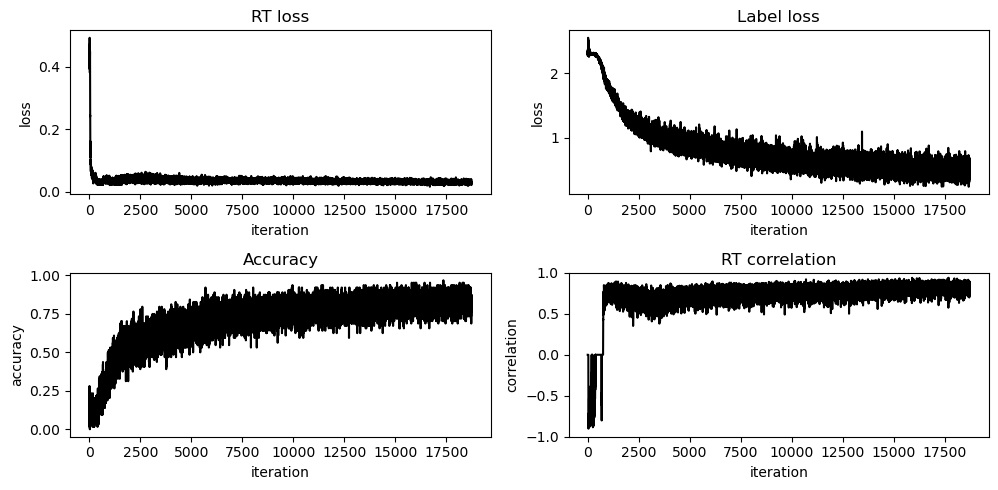

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax = ax.flatten()
ax[0].plot(rt_loss, '-k')
ax[0].set_title('RT loss')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('loss')

ax[1].plot(label_loss, '-k')
ax[1].set_title('Label loss')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('loss')

ax[2].plot(acc, '-k')
ax[2].set_title('Accuracy')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('accuracy')

ax[3].plot(corr, '-k')
ax[3].set_ylim(-1, 1)
ax[3].set_title('RT correlation')
ax[3].set_xlabel('iteration')
ax[3].set_ylabel('correlation')
plt.tight_layout()
plt.show()

In [9]:
# Now we can train the model to balance between accuracy and RTs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RTify_LSTM(1, 16, (64, 28, 28), 3, 10, 20).to(device)
label_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

rt_loss, label_loss, acc, avg_rt = [], [], [], []

for epoch in tqdm(range(20)):
    model.train()
    for x, y, rt in train_loader:
        x, y, rt = x.to(device), y.to(device), rt.to(device)
        optimizer.zero_grad()
        logits, rt_pred = model(x)
        rt_loss_temp = rt_pred.mean()
        label_loss_temp = label_criterion(logits, y)
        loss = 5.0*rt_loss_temp + label_loss_temp
        
        rt_loss.append(rt_loss_temp.item())
        label_loss.append(label_loss_temp.item())
        acc.append((logits.argmax(-1) == y).float().mean().item())
        avg_rt.append(rt_pred.mean().item())
        
        loss.backward()
        optimizer.step()

  0%|          | 0/20 [00:00<?, ?it/s]

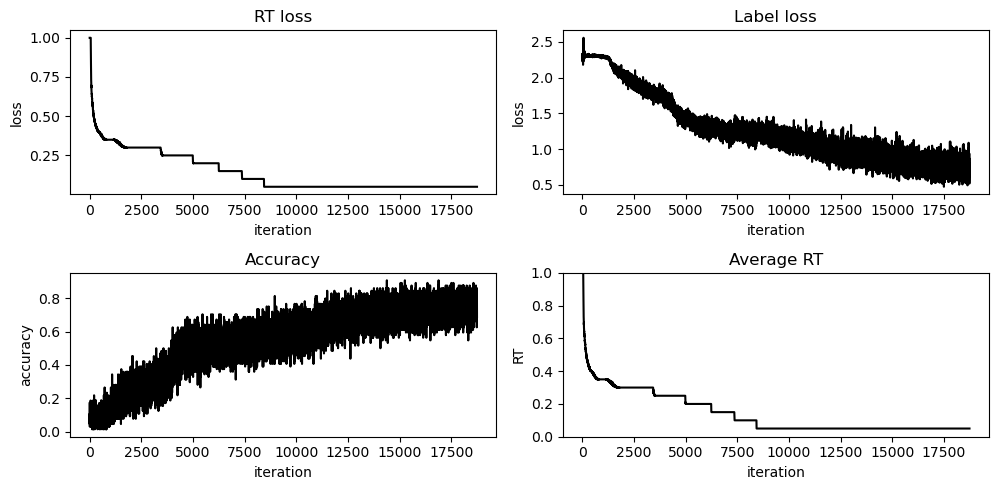

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax = ax.flatten()
ax[0].plot(rt_loss, '-k')
ax[0].set_title('RT loss')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('loss')

ax[1].plot(label_loss, '-k')
ax[1].set_title('Label loss')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('loss')

ax[2].plot(acc, '-k')
ax[2].set_title('Accuracy')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('accuracy')

ax[3].plot(avg_rt, '-k')
ax[3].set_title('Average RT')
ax[3].set_ylim(0, 1)
ax[3].set_xlabel('iteration')
ax[3].set_ylabel('RT')
plt.tight_layout()
plt.show()

In [11]:
# Now we can reduce the penalty on RTs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RTify_LSTM(1, 16, (64, 28, 28), 3, 10, 20).to(device)
label_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

rt_loss, label_loss, acc, avg_rt = [], [], [], []

for epoch in tqdm(range(20)):
    model.train()
    for x, y, rt in train_loader:
        x, y, rt = x.to(device), y.to(device), rt.to(device)
        optimizer.zero_grad()
        logits, rt_pred = model(x)
        rt_loss_temp = rt_pred.mean()
        label_loss_temp = label_criterion(logits, y)
        loss = rt_loss_temp + label_loss_temp
        
        rt_loss.append(rt_loss_temp.item())
        label_loss.append(label_loss_temp.item())
        acc.append((logits.argmax(-1) == y).float().mean().item())
        avg_rt.append(rt_pred.mean().item())
        
        loss.backward()
        optimizer.step()

  0%|          | 0/20 [00:00<?, ?it/s]

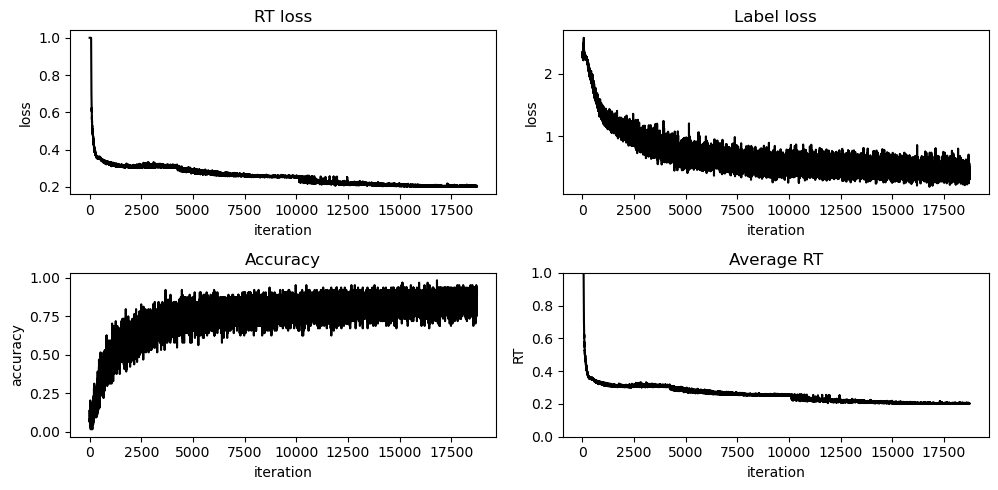

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax = ax.flatten()
ax[0].plot(rt_loss, '-k')
ax[0].set_title('RT loss')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('loss')

ax[1].plot(label_loss, '-k')
ax[1].set_title('Label loss')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('loss')

ax[2].plot(acc, '-k')
ax[2].set_title('Accuracy')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('accuracy')

ax[3].plot(avg_rt, '-k')
ax[3].set_title('Average RT')
ax[3].set_ylim(0, 1)
ax[3].set_xlabel('iteration')
ax[3].set_ylabel('RT')
plt.tight_layout()
plt.show()